# Multinomial classification exercise

click [here](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/02_pytorch_classification_exercise_solutions.ipynb) to read the official solution



# Setup

In [1]:
# Import torch
import torch
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

!pip -q install torchmetrics
from torchmetrics import Accuracy
print("\nAll modules are installed correctly")


All modules are installed correctly


In [2]:
# Hyperparaneters
RANDOM_SEED = 42
TEST_SIZE = 0.2
LEARNING_RATE = 0.02
EPOCHS_NUMBER = 10000
COLOR_MAP = plt.cm.RdYlBu
print("\nAll hyperparaneters are defined correctly")


All hyperparaneters are defined correctly


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")
!nvidia-smi

Using device: cuda

Tue Nov  8 11:19:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

# Data Preparation

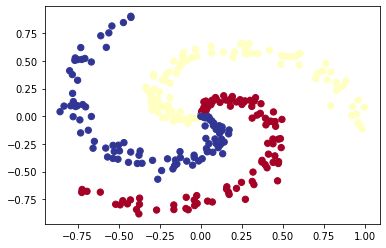

In [4]:
# Reprodubility
np.random.seed(RANDOM_SEED)

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

# Synthetic data
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# Visualize Data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=COLOR_MAP)
plt.show()

In [5]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

# Model Building

In [6]:
class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=10):

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [7]:
# Create an instance of the model
model = SpiralModel(
    input_features=D, # dimensions
    output_features=K, # classes
    hidden_units=10
)

# send model to target device
model.to(device)
print(f'''{model} device: {next(model.parameters()).device}''')

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
) device: cuda:0


# Model Training

In [8]:
# Reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup accuracy function
accuracy_fn = Accuracy().to(device)

# Setup optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set the number of epochs
epochs = EPOCHS_NUMBER

# Training and evaluation loop
for epoch in range(epochs + 1):
    model.train()

    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_probs, dim=1) 

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train.int())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step() 

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_probs = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_probs, dim=1) 

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred, y_test.int())
  
  # Progress Traking
    if epoch % 500 == 0:
        print(f"Epoch: {epoch}   |   Loss: {loss:.4f}, Acc: {acc*100:.2f}%   |   Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%\n")

Epoch: 0   |   Loss: 1.0972, Acc: 35.00%   |   Test Loss: 1.1091, Test Acc: 26.67%

Epoch: 500   |   Loss: 0.9062, Acc: 63.33%   |   Test Loss: 0.9185, Test Acc: 61.67%

Epoch: 1000   |   Loss: 0.6981, Acc: 59.58%   |   Test Loss: 0.7091, Test Acc: 58.33%

Epoch: 1500   |   Loss: 0.6367, Acc: 60.42%   |   Test Loss: 0.6341, Test Acc: 58.33%

Epoch: 2000   |   Loss: 0.5829, Acc: 63.33%   |   Test Loss: 0.5677, Test Acc: 61.67%

Epoch: 2500   |   Loss: 0.5200, Acc: 72.08%   |   Test Loss: 0.4918, Test Acc: 75.00%

Epoch: 3000   |   Loss: 0.4480, Acc: 77.92%   |   Test Loss: 0.4144, Test Acc: 80.00%

Epoch: 3500   |   Loss: 0.3738, Acc: 82.50%   |   Test Loss: 0.3448, Test Acc: 81.67%

Epoch: 4000   |   Loss: 0.3055, Acc: 86.67%   |   Test Loss: 0.2836, Test Acc: 90.00%

Epoch: 4500   |   Loss: 0.2514, Acc: 92.08%   |   Test Loss: 0.2354, Test Acc: 93.33%

Epoch: 5000   |   Loss: 0.2115, Acc: 93.33%   |   Test Loss: 0.1976, Test Acc: 95.00%

Epoch: 5500   |   Loss: 0.1805, Acc: 94.17%   |

# Decision Boundary

In [9]:
def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode(): y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=COLOR_MAP, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=COLOR_MAP)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

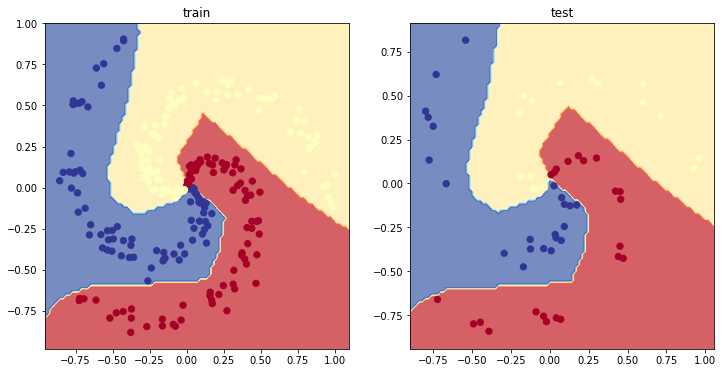

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model, X_test, y_test)